In [24]:
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, classification_report
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [25]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [6]:
non_binaries = [col for col in train.columns if len(train[col].unique().tolist())>2]
binaries = [col for col in train.columns if not col in non_binaries]

In [26]:
x = train.drop('Activity', axis=1)
y = train.Activity
# split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [27]:
# fit model no training data
def fit_eval(X_train,y_train,X_test,y_test, model,early_stopping=0):
    eval_set = [(X_train, y_train), (X_test, y_test)]
    if early_stopping>0:
        model.fit(X_train, y_train, eval_metric=["logloss"],early_stopping_rounds=early_stopping,eval_set=eval_set, verbose=False)
    else:
        model.fit(X_train, y_train, eval_metric=["logloss"],eval_set=eval_set, verbose=False)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # print(classification_report(y_test, y_pred))

    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()

In [ ]:
model = XGBClassifier(n_estimators=200, max_depth=4, learning_rate= 0.1,eval_metric = log_loss, gamma = 0.001, learning_rate = 0.1 , reg_alpha = 2, reg_lambda = 3)
# fit_eval(X_train,y_train,X_test,y_test, model)

In [13]:
model = XGBClassifier(n_estimators = 200, max_depth = 5,reg_alpha = 5, reg_lambda = 8,learning_rate=0.005)
# fit_eval(X_train,y_train,X_test,y_test, model)

Accuracy: 79.48%
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       495
           1       0.82      0.82      0.82       631

    accuracy                           0.79      1126
   macro avg       0.79      0.79      0.79      1126
weighted avg       0.79      0.79      0.79      1126



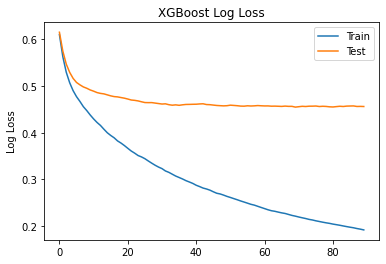

In [39]:
fit_eval(X_train,y_train,X_test,y_test, model, early_stopping=20)

In [28]:
from sklearn.model_selection import StratifiedKFold

In [44]:
kf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)
CV_loss_array    =[]
estimators = [300,600]
max_depths = [5,6]
lrs = [0.001,0.05,0.1] 
for estimator in estimators:
    for lr in lrs :
        for depth in max_depths:

            model = XGBClassifier(n_estimators=estimator, max_depth=depth, learning_rate= lr,eval_metric = log_loss, gamma = 0.001 , reg_alpha = 2, reg_lambda = 4)

            for train_index, test_index in kf.split(x,y):
                X_tr, X_valid = x.values[train_index], x.values[test_index]
                y_tr, y_valid = y.values[train_index], y.values[test_index]
        
                model.fit(X_tr,y_tr,
                        eval_set=[(X_tr, y_tr), (X_valid, y_valid)],
                        verbose=False)

            # results = model.evals_result()
            # epochs = len(results['validation_0']['logloss'])
            # x_axis = range(0, epochs)
            # # plot log loss
            # fig, ax = plt.subplots()
            # ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
            # ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
            # ax.legend()
            # plt.ylabel('Log Loss')
            # plt.title(f'XGBoost Log Loss n_estimators:{estimator}, lr:{lr}')
            # plt.show()  
                probas_train = model.predict_proba(X_valid)[:,1]                 
                CV_loss_array.append(log_loss(y_valid,probas_train))
            print(f'Params: n_estimators:{estimator}, max_depth:{depth}, lr:{lr}; mean loss {np.mean(CV_loss_array)}')

Params: n_estimators:300, max_depth:5, lr:0.001; mean loss 0.6171719222827747
Params: n_estimators:300, max_depth:6, lr:0.001; mean loss 0.6162111761917182
Params: n_estimators:300, max_depth:5, lr:0.05; mean loss 0.5586319155989147
Params: n_estimators:300, max_depth:6, lr:0.05; mean loss 0.5310941837590661
Params: n_estimators:300, max_depth:5, lr:0.1; mean loss 0.5180614601475676
Params: n_estimators:300, max_depth:6, lr:0.1; mean loss 0.5111987948281824
Params: n_estimators:600, max_depth:5, lr:0.001; mean loss 0.5198588579059019
Params: n_estimators:600, max_depth:6, lr:0.001; mean loss 0.5258998880323932
Params: n_estimators:600, max_depth:5, lr:0.05; mean loss 0.5188828760285531
Params: n_estimators:600, max_depth:6, lr:0.05; mean loss 0.51438664540287
Params: n_estimators:600, max_depth:5, lr:0.1; mean loss 0.5114738022838108
Params: n_estimators:600, max_depth:6, lr:0.1; mean loss 0.5088134273171268


## Submission

In [234]:
probas = model.predict_proba(test)[:,1]
submission = pd.DataFrame({'MoleculeId':[x for x in range(1,len(test)+1)],'PredictedProbability':probas})
submission.to_csv('submission_xgboost_regul.csv',index=False)